<a href="https://colab.research.google.com/github/IMOKURI/atmacup11/blob/main/atmacup11_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this notebook ...

- Competition site: [atma cup #11](https://www.guruguru.science/competitions/17/)
- [WandB training logs](https://wandb.ai/imokuri/atma11)







## Prepare for Colab

In [1]:
!nvidia-smi

Thu Jul 15 00:28:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    39W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys

if os.path.exists('init.txt'):
    print("Already initialized.")

else:
    if 'google.colab' in sys.modules:
        from google.colab import drive
        drive.mount('/gdrive')

        !cp /gdrive/MyDrive/Datasets/dataset_atmaCup11.zip .

        !unzip dataset_atmaCup11.zip
        !mkdir -p photos
        !unzip photos.zip -d photos
        !mv 'atmaCup#11_sample_submission.csv' atmaCup11_sample_submission.csv

    # for StratifiedGroupKFold
    !pip uninstall -y scikit-learn
    !pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

    !pip install -q wandb
    !pip install -Uq timm
    !pip install -Uq albumentations

    !touch init.txt

Already initialized.


## Library

In [3]:
import glob
import json
import math
import os
import random
import time
import warnings
from contextlib import contextmanager

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from albumentations.pytorch import ToTensorV2
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [4]:
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
!wandb login 99be4cf161ada45b19189d933d9bae42e9928398

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
wandb_job_type = ""
wandb_notes = ""
wandb_tags = []

## Load Data

In [8]:
DATA_DIR = "../input/atmacup11/"
BASE_DIR = "../input/atmacup11/photos/"
OUTPUT_DIR = "./"

if 'google.colab' in sys.modules:
    DATA_DIR = "./"
    BASE_DIR = "./photos/"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [9]:
paths = [path for path in glob.glob(BASE_DIR + "*.jpg")]
print(len(paths))

9856


In [10]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "atmaCup11_sample_submission.csv")
material = pd.read_csv(DATA_DIR + "materials.csv")
technique = pd.read_csv(DATA_DIR + "techniques.csv")

In [11]:
# https://www.guruguru.science/competitions/17/discussions/000d76a9-fc4b-443e-95f2-5c066c0f3108/
train["sorting_date_target"] = train["sorting_date"] / 100.0 - 15.51

In [12]:
for ds in [train, test, sub]:
    print(f"=" * 80)
    ds.info()
    display(ds.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3937 entries, 0 to 3936
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   object_id            3937 non-null   object 
 1   sorting_date         3937 non-null   int64  
 2   art_series_id        3937 non-null   object 
 3   target               3937 non-null   int64  
 4   sorting_date_target  3937 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 153.9+ KB


,object_id,sorting_date,art_series_id,target,sorting_date_target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1,0.80
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3,3.49
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3,2.83
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2,1.92
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3,3.34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5919 entries, 0 to 5918
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   object_id  5919 non-null   object
dtypes: object(1)
memory usage: 46.4+ KB


,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5919 entries, 0 to 5918
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  5919 non-null   int64
dtypes: int64(1)
memory usage: 46.4 KB


,target
0,3
1,1
2,3
3,3
4,0


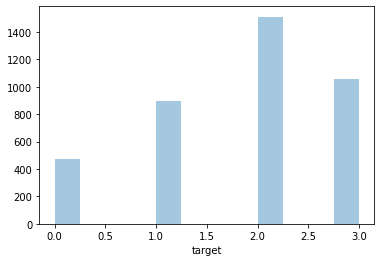

In [13]:
sns.distplot(train["target"], kde=False)

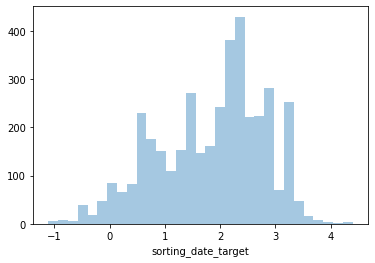

In [14]:
sns.distplot(train["sorting_date_target"], kde=False)

In [15]:
train["art_series_id"].value_counts()

607c22f5e66e8d50a298    9
6fb734ceff36fe2184b5    7
78db88c5ca6d7f6f4ac6    6
f8b88aff7f66a106ba3f    4
600db76c79a01bc40eb1    4
                       ..
f526a1968fc4f681e5df    1
4e5601eead15ae1f9fc1    1
668c0a1bde854cb5a9a5    1
3a91e91345a917ec247f    1
66cbd46ef0d410c03f4c    1
Name: art_series_id, Length: 3784, dtype: int64

## Config

In [16]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "atma11"
    print_freq = 50

    train = True
    validate = False
    inference = False

    debug = False
    multi_gpu = False
    apex = False


In [17]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

In [18]:
if Config.apex:
    from apex import amp

In [19]:
seed = random.randrange(10000)
# seed = 440

print(seed)

In [20]:
config_defaults = {
    "seed": seed,
    "size": 256,
    "n_class": 1,
    "n_fold": 5,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "num_workers": 4,
    "batch_size": 16,
    "epochs": 20,
    "scheduler": "CosineAnnealingWarmRestarts",
    "criterion": "RMSELoss",
    "lr": 1e-3,
    "min_lr": 1e-4,
    "weight_decay": 1e-6,
    "model_name": "resnetrs50",
    "inference_runs": [
        "3r29llv1", # 36
        "2r8nooek", # 33
        "1t1k9jk5", # 34
    ],
    "no_aug": True,
}


In [21]:
if config_defaults["scheduler"] == "CosineAnnealingWarmRestarts":
    config_defaults["T_0"] = config_defaults["epochs"]

elif config_defaults["scheduler"] == "CosineAnnealingLR":
    config_defaults["T_max"] = config_defaults["epochs"]

elif config_defaults["scheduler"] == "ReduceLROnPlateau":
    config_defaults["factor"] = 0.2
    config_defaults["patience"] = 4
    config_defaults["eps"] = 1e-6


In [22]:
if Config.debug:
    config_defaults["epochs"] = 1

In [23]:
if Config.debug:
    wandb.init(project=Config.wandb_project, config=config_defaults, mode="disabled")
else:
    wandb.init(project=Config.wandb_project, config=config_defaults, notes=wandb_notes, tags=wandb_tags, job_type=wandb_job_type, save_code=True)

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [24]:
config = wandb.config

## Load Models

In [25]:
if Config.validate or Config.inference:
    api = wandb.Api()
    inference_models = []

    for n, run_id in enumerate(config.inference_runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        try:
            for file in run.files():
                file.download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        inference_model = {}
        inference_model["run_id"] = run_id
        inference_model["model_name"] = run.config["model_name"]
        
        for fold in range(config.n_fold):
            model_preds = torch.load(f"{run_id}/{inference_model['model_name']}_fold{fold}_best.pth")
            inference_model[f"state_fold{fold}"] = model_preds["model"]
            inference_model[f"preds_fold{fold}"] = model_preds["preds"]

        oof = pd.read_csv(f"{run_id}/oof_df.csv")[["object_id", "preds"]]
        oof.columns = ["object_id", f"preds{n}"]
        train = pd.merge(train, oof, on="object_id", )

        inference_models.append(inference_model)
    
    print(train.columns)
    print({m['run_id']: m['model_name'] for m in inference_models})

In [26]:
if Config.debug:
    train = train.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    test = test.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    sub = sub.sample(n=1000, random_state=config.seed).reset_index(drop=True)

## Utils

In [27]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)


## CV Split

In [28]:
folds = train.copy()
Fold = StratifiedGroupKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["target"], folds["art_series_id"])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(np.uint8)
print(folds.groupby(["fold", "target"]).size())


fold  target
0     0         111
      1         178
      2         279
      3         218
1     0         110
      1         181
      2         301
      3         202
2     0          82
      1         168
      2         322
      3         206
3     0          94
      1         194
      2         284
      3         211
4     0          78
      1         175
      2         325
      3         218
dtype: int64


## Dataset

In [29]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["object_id"].values
        self.labels = df["sorting_date_target"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{BASE_DIR}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).float()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["object_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{BASE_DIR}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image


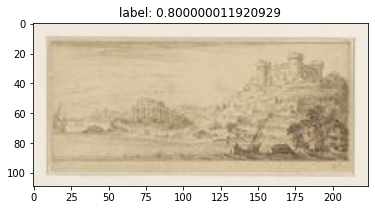

In [30]:
# Test

train_ds = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_ds[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()


## Transform

In [31]:
def get_transforms(*, data):

    if data == "train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size, scale=(0.5, 1.0)),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                A.CoarseDropout(p=0.5),
                A.Cutout(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "weak_train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size, scale=(0.5, 1.0)),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                # A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                # A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                # A.CoarseDropout(p=0.5),
                # A.Cutout(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return A.Compose(
            [
                A.Resize(config.size, config.size),
                # A.CenterCrop(config.size, config.size),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )


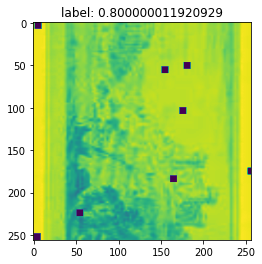

In [32]:
# Test

train_ds = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_ds[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()


## Model

In [33]:
class Atma11Net(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "res" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, config.n_class)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, config.n_class)

        elif model_name.startswith("vit_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, config.n_class)
            
        elif "nfnet" in model_name:
            n_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Linear(n_features, config.n_class)

    def forward(self, x):
        x = self.model(x).view(x.size(0))
        return x


In [34]:
# Test

model = Atma11Net(model_name=config.model_name, pretrained=False)
print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break


Atma11Net(
  (model): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): 

## Loss

In [35]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss


## Scoring

In [36]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [37]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["target"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    # wandb.log({"fold": fold, "CV": score})
    if fold == config.n_fold:
        wandb.run.summary[f"CV"] = score
    else:
        wandb.run.summary[f"CV_fold{fold}"] = score


## Helper functions

In [38]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [39]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        y_preds = model(images.float())

        loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps
        if Config.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.val:.4f}({losses.avg:.4f}) "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_last_lr()[0]:.6f}  "
            )

    return losses.avg

In [40]:
def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # compute loss
        with torch.no_grad():
            y_preds = model(images)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # record accuracy
        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.val:.4f}({losses.avg:.4f}) "
            )
    predictions = np.clip(np.concatenate(preds), 0, 3)
    return losses.avg, predictions

In [41]:
def inference(test_loader):
    predictions = []
    for model_item in inference_models:
        for fold in range(config.n_fold):
            LOGGER.info(f"========== ID: {model_item['run_id']} model: {model_item['model_name']} fold: {fold} inference ==========")
            model = Atma11Net(model_item["model_name"])
            model.to(device)
            model.load_state_dict(model_item[f"state_fold{fold}"])
            model.eval()
            preds = []
            for i, (images) in enumerate(test_loader):
                images = images.to(device)
                with torch.no_grad():
                    y_preds = model(images)
                # avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
                preds.append(y_preds.to("cpu").numpy())
            preds = np.concatenate(preds)
            predictions.append(preds)
    predictions = np.clip(np.mean(predictions, axis=0), 0, 3)
    return predictions


## Train loop

In [42]:
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_weak_aug = TrainDataset(train_folds, transform=get_transforms(data="weak_train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_weak_aug = DataLoader(
        train_dataset_weak_aug,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if config.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=config.factor, patience=config.patience, verbose=True, eps=config.eps
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        return scheduler

    # ====================================================
    # Model & Optimizer
    # ====================================================
    model = Atma11Net(config.model_name)
    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not Config.apex and Config.multi_gpu:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # Apex
    # ====================================================
    if Config.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "RMSELoss":
            criterion = RMSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Loop
    # ====================================================
    best_score = np.inf
    best_loss = np.inf

    # if not Config.multi_gpu:
    #     wandb.watch(model, log_freq=Config.print_freq)

    for epoch in range(config.epochs):

        start_time = time.time()

        # train
        if config.no_aug or epoch <= 1 or epoch >= config.epochs - 2:
            avg_loss = train_fn(train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device)
        elif epoch >= config.epochs - 5:
            avg_loss = train_fn(train_loader_weak_aug, model, criterion, optimizer, epoch, scheduler, device)
        else:
            avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["target"].values

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/val_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        if score < best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth"
            )
            wandb.save(OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth")

        # if epoch == config.epochs - 1:
        #     LOGGER.info(f"Epoch {epoch+1} - Save final model")
        #     torch.save(
        #         {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name}_fold{fold}_final.pth"
        #     )

    check_point = torch.load(OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth")

    valid_folds[[str(c) for c in range(config.n_class)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"]  # .argmax(1)

    return valid_folds

## Main


In [43]:
def main():
    if Config.train:
        oof_df = pd.DataFrame()
        for fold in range(config.n_fold):
            _oof_df = train_loop(folds, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")
        
    if Config.validate:
        probs = []

        for n, model_item in enumerate(inference_models):
            probs.append(train[f"preds{n}"].values)
        preds = np.mean(probs, axis=0)

        train["preds"] = np.clip(preds, 0, 3)

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(train)
        
        # save result
        train.to_csv(OUTPUT_DIR + "validation_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "validation_df.csv")

    if Config.inference:
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True
        )
        predictions = inference(test_loader)

        # submission
        sub["target"] = predictions  # .argmax(1)
        sub.to_csv(OUTPUT_DIR + "submission.csv", index=False)
        wandb.save(OUTPUT_DIR + "submission.csv")


In [44]:
if __name__ == "__main__":
    main()


========== fold: 0 training ==========


Epoch: [1][0/196] Elapsed 0m 0s (remain 2m 19s) Loss: 2.1366(2.1366) Grad: 16.4596 LR: 0.001000  
Epoch: [1][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.9008(1.1311) Grad: 7.8226 LR: 0.001000  
Epoch: [1][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0209(1.0622) Grad: 9.7184 LR: 0.001000  
Epoch: [1][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0618(1.0291) Grad: 2.8478 LR: 0.001000  
Epoch: [1][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.5167(1.0190) Grad: 4.2183 LR: 0.001000  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 14s) Loss: 0.9420(0.9420) 


Epoch 1 - avg_train_loss: 1.0190  avg_val_loss: 1.0540  time: 45s
Epoch 1 - Score: 1.0553624472445733
Epoch 1 - Save Best Score: 1.0554 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0401(1.0540) 
Epoch: [2][0/196] Elapsed 0m 0s (remain 2m 36s) Loss: 0.9023(0.9023) Grad: 8.6766 LR: 0.000994  
Epoch: [2][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8679(0.9475) Grad: 2.1695 LR: 0.000994  
Epoch: [2][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0563(0.9396) Grad: 6.0382 LR: 0.000994  
Epoch: [2][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.5049(0.9264) Grad: 12.2138 LR: 0.000994  
Epoch: [2][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 1.1387(0.9323) Grad: 5.8006 LR: 0.000994  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 18s) Loss: 0.8401(0.8401) 


Epoch 2 - avg_train_loss: 0.9323  avg_val_loss: 0.9696  time: 45s
Epoch 2 - Score: 0.9975205512968982
Epoch 2 - Save Best Score: 0.9975 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9132(0.9696) 
Epoch: [3][0/196] Elapsed 0m 0s (remain 2m 22s) Loss: 0.8178(0.8178) Grad: 3.1992 LR: 0.000978  
Epoch: [3][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8713(0.9139) Grad: 4.3799 LR: 0.000978  
Epoch: [3][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9059(0.9001) Grad: 4.1950 LR: 0.000978  
Epoch: [3][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7082(0.8897) Grad: 4.9365 LR: 0.000978  
Epoch: [3][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8420(0.9028) Grad: 1.7076 LR: 0.000978  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7157(0.7157) 


Epoch 3 - avg_train_loss: 0.9028  avg_val_loss: 0.9048  time: 45s
Epoch 3 - Score: 0.9280631417134378
Epoch 3 - Save Best Score: 0.9281 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3732(0.9048) 
Epoch: [4][0/196] Elapsed 0m 0s (remain 2m 29s) Loss: 0.9120(0.9120) Grad: 2.1592 LR: 0.000951  
Epoch: [4][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 1.1736(0.9132) Grad: 7.9811 LR: 0.000951  
Epoch: [4][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7622(0.8785) Grad: 2.2086 LR: 0.000951  
Epoch: [4][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0952(0.8728) Grad: 3.9665 LR: 0.000951  
Epoch: [4][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7367(0.8790) Grad: 1.9501 LR: 0.000951  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.7500(0.7500) 


Epoch 4 - avg_train_loss: 0.8790  avg_val_loss: 0.9311  time: 45s
Epoch 4 - Score: 0.9594421892865755


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5650(0.9311) 
Epoch: [5][0/196] Elapsed 0m 0s (remain 1m 51s) Loss: 0.7244(0.7244) Grad: 3.7146 LR: 0.000914  
Epoch: [5][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.7230(0.8525) Grad: 2.0567 LR: 0.000914  
Epoch: [5][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9250(0.8794) Grad: 1.7230 LR: 0.000914  
Epoch: [5][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0998(0.8808) Grad: 1.6618 LR: 0.000914  
Epoch: [5][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8946(0.8791) Grad: 3.0632 LR: 0.000914  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.7381(0.7381) 


Epoch 5 - avg_train_loss: 0.8791  avg_val_loss: 0.9200  time: 44s
Epoch 5 - Score: 0.9578915759323975


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4686(0.9200) 
Epoch: [6][0/196] Elapsed 0m 0s (remain 1m 54s) Loss: 0.7978(0.7978) Grad: 3.4667 LR: 0.000868  
Epoch: [6][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.8562(0.8624) Grad: 4.2694 LR: 0.000868  
Epoch: [6][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8796(0.8765) Grad: 4.3629 LR: 0.000868  
Epoch: [6][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9596(0.8713) Grad: 3.3132 LR: 0.000868  
Epoch: [6][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8841(0.8707) Grad: 1.5254 LR: 0.000868  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 13s) Loss: 0.5795(0.5795) 


Epoch 6 - avg_train_loss: 0.8707  avg_val_loss: 0.8719  time: 44s
Epoch 6 - Score: 0.9068119021144272
Epoch 6 - Save Best Score: 0.9068 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4016(0.8719) 
Epoch: [7][0/196] Elapsed 0m 0s (remain 2m 26s) Loss: 0.6901(0.6901) Grad: 3.3957 LR: 0.000815  
Epoch: [7][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8042(0.8387) Grad: 3.4370 LR: 0.000815  
Epoch: [7][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7414(0.8370) Grad: 4.6921 LR: 0.000815  
Epoch: [7][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0135(0.8520) Grad: 2.1336 LR: 0.000815  
Epoch: [7][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.6632(0.8564) Grad: 4.6299 LR: 0.000815  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 18s) Loss: 0.9780(0.9780) 


Epoch 7 - avg_train_loss: 0.8564  avg_val_loss: 1.0929  time: 44s
Epoch 7 - Score: 1.0887819978361581


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7352(1.0929) 
Epoch: [8][0/196] Elapsed 0m 0s (remain 1m 49s) Loss: 0.7540(0.7540) Grad: 4.9026 LR: 0.000754  
Epoch: [8][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.7213(0.8381) Grad: 2.3283 LR: 0.000754  
Epoch: [8][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7043(0.8591) Grad: 4.8882 LR: 0.000754  
Epoch: [8][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7536(0.8579) Grad: 5.1263 LR: 0.000754  
Epoch: [8][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8620(0.8585) Grad: 1.3188 LR: 0.000754  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.8151(0.8151) 


Epoch 8 - avg_train_loss: 0.8585  avg_val_loss: 1.0000  time: 45s
Epoch 8 - Score: 1.0029088011616785


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7366(1.0000) 
Epoch: [9][0/196] Elapsed 0m 0s (remain 1m 51s) Loss: 0.6623(0.6623) Grad: 6.1081 LR: 0.000689  
Epoch: [9][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 0.7526(0.8375) Grad: 1.9406 LR: 0.000689  
Epoch: [9][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.9662(0.8561) Grad: 6.7410 LR: 0.000689  
Epoch: [9][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0073(0.8578) Grad: 3.0011 LR: 0.000689  
Epoch: [9][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 1.0221(0.8501) Grad: 4.0181 LR: 0.000689  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.9897(0.9897) 


Epoch 9 - avg_train_loss: 0.8501  avg_val_loss: 0.9524  time: 44s
Epoch 9 - Score: 0.9848022054501077


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4895(0.9524) 
Epoch: [10][0/196] Elapsed 0m 0s (remain 1m 51s) Loss: 1.0405(1.0405) Grad: 3.6233 LR: 0.000620  
Epoch: [10][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 1.0997(0.8414) Grad: 5.0907 LR: 0.000620  
Epoch: [10][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9514(0.8437) Grad: 3.4278 LR: 0.000620  
Epoch: [10][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9141(0.8348) Grad: 2.2600 LR: 0.000620  
Epoch: [10][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.9299(0.8429) Grad: 2.2921 LR: 0.000620  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 13s) Loss: 0.7253(0.7253) 


Epoch 10 - avg_train_loss: 0.8429  avg_val_loss: 0.9203  time: 44s
Epoch 10 - Score: 0.9692797664733847


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5273(0.9203) 
Epoch: [11][0/196] Elapsed 0m 0s (remain 1m 49s) Loss: 0.8106(0.8106) Grad: 3.3383 LR: 0.000550  
Epoch: [11][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 1.0547(0.8861) Grad: 5.1023 LR: 0.000550  
Epoch: [11][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.8849(0.8452) Grad: 6.4713 LR: 0.000550  
Epoch: [11][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8266(0.8397) Grad: 2.4659 LR: 0.000550  
Epoch: [11][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8725(0.8460) Grad: 1.9808 LR: 0.000550  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8315(0.8315) 


Epoch 11 - avg_train_loss: 0.8460  avg_val_loss: 0.9716  time: 44s
Epoch 11 - Score: 1.003054656810896


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.8276(0.9716) 
Epoch: [12][0/196] Elapsed 0m 0s (remain 1m 40s) Loss: 0.8690(0.8690) Grad: 2.6166 LR: 0.000480  
Epoch: [12][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 0.7272(0.8259) Grad: 4.3684 LR: 0.000480  
Epoch: [12][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.9787(0.8355) Grad: 3.7186 LR: 0.000480  
Epoch: [12][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8480(0.8273) Grad: 2.0786 LR: 0.000480  
Epoch: [12][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8610(0.8281) Grad: 3.9381 LR: 0.000480  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 14s) Loss: 1.0565(1.0565) 


Epoch 12 - avg_train_loss: 0.8281  avg_val_loss: 1.0623  time: 44s
Epoch 12 - Score: 1.0643422786535002


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7853(1.0623) 
Epoch: [13][0/196] Elapsed 0m 0s (remain 1m 42s) Loss: 0.8374(0.8374) Grad: 2.1065 LR: 0.000411  
Epoch: [13][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.9033(0.8305) Grad: 2.7226 LR: 0.000411  
Epoch: [13][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8131(0.8008) Grad: 1.0426 LR: 0.000411  
Epoch: [13][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.4632(0.8115) Grad: 2.7120 LR: 0.000411  
Epoch: [13][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.9109(0.8174) Grad: 2.0394 LR: 0.000411  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.7176(0.7176) 


Epoch 13 - avg_train_loss: 0.8174  avg_val_loss: 0.8652  time: 44s
Epoch 13 - Score: 0.893342397440568
Epoch 13 - Save Best Score: 0.8933 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5636(0.8652) 
Epoch: [14][0/196] Elapsed 0m 0s (remain 2m 23s) Loss: 0.8056(0.8056) Grad: 3.1727 LR: 0.000346  
Epoch: [14][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.7608(0.7962) Grad: 1.8209 LR: 0.000346  
Epoch: [14][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.6072(0.8033) Grad: 3.6530 LR: 0.000346  
Epoch: [14][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8652(0.8030) Grad: 2.4252 LR: 0.000346  
Epoch: [14][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8412(0.8051) Grad: 1.9044 LR: 0.000346  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 0.6124(0.6124) 


Epoch 14 - avg_train_loss: 0.8051  avg_val_loss: 0.8805  time: 45s
Epoch 14 - Score: 0.9009097878134553


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4766(0.8805) 
Epoch: [15][0/196] Elapsed 0m 0s (remain 1m 59s) Loss: 0.8304(0.8304) Grad: 2.9034 LR: 0.000285  
Epoch: [15][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.9969(0.8027) Grad: 1.5809 LR: 0.000285  
Epoch: [15][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.6887(0.7972) Grad: 4.3055 LR: 0.000285  
Epoch: [15][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.6420(0.8001) Grad: 1.8395 LR: 0.000285  
Epoch: [15][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7283(0.8092) Grad: 3.9961 LR: 0.000285  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.5595(0.5595) 


Epoch 15 - avg_train_loss: 0.8092  avg_val_loss: 0.8299  time: 44s
Epoch 15 - Score: 0.8660741679984043
Epoch 15 - Save Best Score: 0.8661 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4785(0.8299) 
Epoch: [16][0/196] Elapsed 0m 0s (remain 2m 32s) Loss: 0.8038(0.8038) Grad: 3.7738 LR: 0.000232  
Epoch: [16][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8106(0.8084) Grad: 2.7423 LR: 0.000232  
Epoch: [16][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7399(0.8248) Grad: 1.9061 LR: 0.000232  
Epoch: [16][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.6760(0.8052) Grad: 3.2037 LR: 0.000232  
Epoch: [16][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8233(0.8065) Grad: 3.1418 LR: 0.000232  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.7358(0.7358) 


Epoch 16 - avg_train_loss: 0.8065  avg_val_loss: 0.8918  time: 45s
Epoch 16 - Score: 0.9143097831737107


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7123(0.8918) 
Epoch: [17][0/196] Elapsed 0m 0s (remain 1m 49s) Loss: 0.5961(0.5961) Grad: 3.3093 LR: 0.000186  
Epoch: [17][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.9559(0.7891) Grad: 3.9988 LR: 0.000186  
Epoch: [17][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.9181(0.8002) Grad: 2.7283 LR: 0.000186  
Epoch: [17][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9268(0.8001) Grad: 2.8501 LR: 0.000186  
Epoch: [17][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6326(0.7975) Grad: 4.6210 LR: 0.000186  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.4831(0.4831) 


Epoch 17 - avg_train_loss: 0.7975  avg_val_loss: 0.8525  time: 44s
Epoch 17 - Score: 0.9039871993630207


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6338(0.8525) 
Epoch: [18][0/196] Elapsed 0m 0s (remain 1m 38s) Loss: 0.8812(0.8812) Grad: 2.6236 LR: 0.000149  
Epoch: [18][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 1.0032(0.7928) Grad: 2.3129 LR: 0.000149  
Epoch: [18][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.7350(0.7933) Grad: 5.7319 LR: 0.000149  
Epoch: [18][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8995(0.8029) Grad: 2.9284 LR: 0.000149  
Epoch: [18][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6104(0.7895) Grad: 2.4239 LR: 0.000149  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 0.4823(0.4823) 


Epoch 18 - avg_train_loss: 0.7895  avg_val_loss: 0.8466  time: 44s
Epoch 18 - Score: 0.8945709654413192


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7212(0.8466) 
Epoch: [19][0/196] Elapsed 0m 0s (remain 1m 41s) Loss: 0.8190(0.8190) Grad: 5.3693 LR: 0.000122  
Epoch: [19][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 0.9222(0.7563) Grad: 4.5045 LR: 0.000122  
Epoch: [19][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.9538(0.7456) Grad: 4.2980 LR: 0.000122  
Epoch: [19][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8199(0.7511) Grad: 3.4636 LR: 0.000122  
Epoch: [19][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7083(0.7643) Grad: 2.4975 LR: 0.000122  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.6291(0.6291) 


Epoch 19 - avg_train_loss: 0.7643  avg_val_loss: 0.8458  time: 44s
Epoch 19 - Score: 0.8845555934183185


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6883(0.8458) 
Epoch: [20][0/196] Elapsed 0m 0s (remain 1m 56s) Loss: 0.7418(0.7418) Grad: 7.2960 LR: 0.000106  
Epoch: [20][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.7980(0.7274) Grad: 3.0586 LR: 0.000106  
Epoch: [20][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7524(0.7523) Grad: 4.8305 LR: 0.000106  
Epoch: [20][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.1131(0.7641) Grad: 5.8050 LR: 0.000106  
Epoch: [20][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7112(0.7712) Grad: 4.6828 LR: 0.000106  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7672(0.7672) 


Epoch 20 - avg_train_loss: 0.7712  avg_val_loss: 0.8485  time: 44s
Epoch 20 - Score: 0.8833720759483101


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6776(0.8485) 


========== fold: 0 result ==========
Score: 0.86607
========== fold: 1 training ==========


Epoch: [1][0/196] Elapsed 0m 0s (remain 1m 39s) Loss: 2.3051(2.3051) Grad: 16.3725 LR: 0.001000  
Epoch: [1][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 0.9088(1.1573) Grad: 2.5902 LR: 0.001000  
Epoch: [1][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 1.5409(1.0806) Grad: 6.8127 LR: 0.001000  
Epoch: [1][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8795(1.0347) Grad: 5.3972 LR: 0.001000  
Epoch: [1][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8127(1.0126) Grad: 5.2047 LR: 0.001000  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 1.0666(1.0666) 


Epoch 1 - avg_train_loss: 1.0126  avg_val_loss: 0.9452  time: 44s
Epoch 1 - Score: 0.9811250083033761
Epoch 1 - Save Best Score: 0.9811 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6315(0.9452) 
Epoch: [2][0/196] Elapsed 0m 0s (remain 2m 24s) Loss: 0.7929(0.7929) Grad: 6.3060 LR: 0.000994  
Epoch: [2][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.7987(0.9250) Grad: 3.8346 LR: 0.000994  
Epoch: [2][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8905(0.9065) Grad: 2.3230 LR: 0.000994  
Epoch: [2][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7466(0.9146) Grad: 2.5629 LR: 0.000994  
Epoch: [2][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.9613(0.9134) Grad: 5.7483 LR: 0.000994  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 18s) Loss: 1.2060(1.2060) 


Epoch 2 - avg_train_loss: 0.9134  avg_val_loss: 0.9446  time: 45s
Epoch 2 - Score: 0.9561639607950881
Epoch 2 - Save Best Score: 0.9562 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7832(0.9446) 
Epoch: [3][0/196] Elapsed 0m 0s (remain 2m 39s) Loss: 1.2627(1.2627) Grad: 3.2778 LR: 0.000978  
Epoch: [3][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.6969(0.9240) Grad: 2.3305 LR: 0.000978  
Epoch: [3][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9183(0.9119) Grad: 1.8086 LR: 0.000978  
Epoch: [3][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0716(0.9086) Grad: 2.5835 LR: 0.000978  
Epoch: [3][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.9613(0.9005) Grad: 2.3257 LR: 0.000978  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 1.6849(1.6849) 


Epoch 3 - avg_train_loss: 0.9005  avg_val_loss: 1.3184  time: 45s
Epoch 3 - Score: 1.3054342564981047


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3534(1.3184) 
Epoch: [4][0/196] Elapsed 0m 0s (remain 1m 51s) Loss: 0.8770(0.8770) Grad: 8.4022 LR: 0.000951  
Epoch: [4][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 0.9836(0.8825) Grad: 5.5258 LR: 0.000951  
Epoch: [4][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 1.1952(0.8921) Grad: 1.5885 LR: 0.000951  
Epoch: [4][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.6529(0.8939) Grad: 2.6781 LR: 0.000951  
Epoch: [4][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6907(0.8961) Grad: 4.2726 LR: 0.000951  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 1.0649(1.0649) 


Epoch 4 - avg_train_loss: 0.8961  avg_val_loss: 0.8827  time: 44s
Epoch 4 - Score: 0.913259951076123
Epoch 4 - Save Best Score: 0.9133 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6998(0.8827) 
Epoch: [5][0/196] Elapsed 0m 0s (remain 2m 31s) Loss: 0.8892(0.8892) Grad: 1.6144 LR: 0.000914  
Epoch: [5][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.9123(0.9138) Grad: 3.9597 LR: 0.000914  
Epoch: [5][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7545(0.8825) Grad: 2.4726 LR: 0.000914  
Epoch: [5][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0588(0.8779) Grad: 6.0469 LR: 0.000914  
Epoch: [5][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8076(0.8755) Grad: 1.2552 LR: 0.000914  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1806(1.1806) 


Epoch 5 - avg_train_loss: 0.8755  avg_val_loss: 0.8927  time: 45s
Epoch 5 - Score: 0.9102824427019635
Epoch 5 - Save Best Score: 0.9103 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8245(0.8927) 
Epoch: [6][0/196] Elapsed 0m 0s (remain 2m 30s) Loss: 0.8906(0.8906) Grad: 1.0973 LR: 0.000868  
Epoch: [6][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 1.0437(0.8544) Grad: 2.1894 LR: 0.000868  
Epoch: [6][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7580(0.8649) Grad: 2.4327 LR: 0.000868  
Epoch: [6][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8075(0.8575) Grad: 2.0188 LR: 0.000868  
Epoch: [6][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7385(0.8580) Grad: 1.0526 LR: 0.000868  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 1.0398(1.0398) 


Epoch 6 - avg_train_loss: 0.8580  avg_val_loss: 0.9207  time: 45s
Epoch 6 - Score: 0.9375175427351171


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8152(0.9207) 
Epoch: [7][0/196] Elapsed 0m 0s (remain 1m 53s) Loss: 0.7044(0.7044) Grad: 1.3004 LR: 0.000815  
Epoch: [7][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.7124(0.8725) Grad: 4.2974 LR: 0.000815  
Epoch: [7][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.8735(0.8649) Grad: 4.0904 LR: 0.000815  
Epoch: [7][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8603(0.8633) Grad: 1.3496 LR: 0.000815  
Epoch: [7][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8732(0.8571) Grad: 4.2838 LR: 0.000815  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.9426(0.9426) 


Epoch 7 - avg_train_loss: 0.8571  avg_val_loss: 0.9019  time: 44s
Epoch 7 - Score: 0.9340969154928153


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6912(0.9019) 
Epoch: [8][0/196] Elapsed 0m 0s (remain 1m 54s) Loss: 0.8074(0.8074) Grad: 3.2885 LR: 0.000754  
Epoch: [8][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8324(0.8361) Grad: 3.2211 LR: 0.000754  
Epoch: [8][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8744(0.8366) Grad: 2.0333 LR: 0.000754  
Epoch: [8][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7708(0.8348) Grad: 2.7546 LR: 0.000754  
Epoch: [8][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4763(0.8281) Grad: 2.0930 LR: 0.000754  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.9576(0.9576) 


Epoch 8 - avg_train_loss: 0.8281  avg_val_loss: 0.8710  time: 44s
Epoch 8 - Score: 0.9019340532424536
Epoch 8 - Save Best Score: 0.9019 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8156(0.8710) 
Epoch: [9][0/196] Elapsed 0m 0s (remain 2m 29s) Loss: 0.9215(0.9215) Grad: 3.8206 LR: 0.000689  
Epoch: [9][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.7712(0.8241) Grad: 2.1196 LR: 0.000689  
Epoch: [9][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8898(0.8227) Grad: 5.1746 LR: 0.000689  
Epoch: [9][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0260(0.8198) Grad: 2.7860 LR: 0.000689  
Epoch: [9][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.9663(0.8210) Grad: 3.2884 LR: 0.000689  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 14s) Loss: 1.0843(1.0843) 


Epoch 9 - avg_train_loss: 0.8210  avg_val_loss: 0.8499  time: 45s
Epoch 9 - Score: 0.8737135319818919
Epoch 9 - Save Best Score: 0.8737 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6463(0.8499) 
Epoch: [10][0/196] Elapsed 0m 0s (remain 2m 21s) Loss: 0.7641(0.7641) Grad: 1.5639 LR: 0.000620  
Epoch: [10][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.7200(0.7907) Grad: 3.3214 LR: 0.000620  
Epoch: [10][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.6589(0.8206) Grad: 2.1286 LR: 0.000620  
Epoch: [10][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.6637(0.8173) Grad: 1.9851 LR: 0.000620  
Epoch: [10][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7875(0.8155) Grad: 1.1261 LR: 0.000620  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 1.0143(1.0143) 


Epoch 10 - avg_train_loss: 0.8155  avg_val_loss: 0.8511  time: 44s
Epoch 10 - Score: 0.9024597958868755


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6809(0.8511) 
Epoch: [11][0/196] Elapsed 0m 0s (remain 2m 0s) Loss: 0.5970(0.5970) Grad: 4.4706 LR: 0.000550  
Epoch: [11][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.8032(0.8109) Grad: 4.0664 LR: 0.000550  
Epoch: [11][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0787(0.8050) Grad: 6.7449 LR: 0.000550  
Epoch: [11][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8895(0.8083) Grad: 2.1568 LR: 0.000550  
Epoch: [11][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.6690(0.8005) Grad: 3.9174 LR: 0.000550  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.9698(0.9698) 


Epoch 11 - avg_train_loss: 0.8005  avg_val_loss: 0.8828  time: 44s
Epoch 11 - Score: 0.9348224496654238


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6756(0.8828) 
Epoch: [12][0/196] Elapsed 0m 0s (remain 1m 55s) Loss: 0.6442(0.6442) Grad: 3.2687 LR: 0.000480  
Epoch: [12][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 0.7399(0.7395) Grad: 1.8580 LR: 0.000480  
Epoch: [12][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.5359(0.7821) Grad: 5.4472 LR: 0.000480  
Epoch: [12][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7211(0.7928) Grad: 6.1002 LR: 0.000480  
Epoch: [12][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.9387(0.7953) Grad: 3.2510 LR: 0.000480  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 1.0555(1.0555) 


Epoch 12 - avg_train_loss: 0.7953  avg_val_loss: 0.8806  time: 44s
Epoch 12 - Score: 0.9233565783239325


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8406(0.8806) 
Epoch: [13][0/196] Elapsed 0m 0s (remain 1m 54s) Loss: 0.9751(0.9751) Grad: 2.4617 LR: 0.000411  
Epoch: [13][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.4960(0.7762) Grad: 3.3558 LR: 0.000411  
Epoch: [13][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 1.2388(0.7754) Grad: 5.0547 LR: 0.000411  
Epoch: [13][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.6664(0.7813) Grad: 2.5921 LR: 0.000411  
Epoch: [13][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.5728(0.7886) Grad: 3.0483 LR: 0.000411  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 1.0297(1.0297) 


Epoch 13 - avg_train_loss: 0.7886  avg_val_loss: 0.8422  time: 44s
Epoch 13 - Score: 0.8758415508978301


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6698(0.8422) 
Epoch: [14][0/196] Elapsed 0m 0s (remain 1m 43s) Loss: 0.9078(0.9078) Grad: 1.9951 LR: 0.000346  
Epoch: [14][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 0.7906(0.7948) Grad: 3.8028 LR: 0.000346  
Epoch: [14][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.7616(0.7742) Grad: 4.6843 LR: 0.000346  
Epoch: [14][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7674(0.7810) Grad: 3.8599 LR: 0.000346  
Epoch: [14][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7184(0.7740) Grad: 0.9725 LR: 0.000346  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.8956(0.8956) 


Epoch 14 - avg_train_loss: 0.7740  avg_val_loss: 0.8095  time: 44s
Epoch 14 - Score: 0.8394144414087277
Epoch 14 - Save Best Score: 0.8394 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6655(0.8095) 
Epoch: [15][0/196] Elapsed 0m 0s (remain 2m 38s) Loss: 0.7020(0.7020) Grad: 3.4809 LR: 0.000285  
Epoch: [15][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 1.0083(0.8055) Grad: 5.6260 LR: 0.000285  
Epoch: [15][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8170(0.7687) Grad: 3.5095 LR: 0.000285  
Epoch: [15][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9546(0.7673) Grad: 5.7511 LR: 0.000285  
Epoch: [15][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.6568(0.7679) Grad: 3.6947 LR: 0.000285  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 14s) Loss: 0.9143(0.9143) 


Epoch 15 - avg_train_loss: 0.7679  avg_val_loss: 0.8260  time: 44s
Epoch 15 - Score: 0.8761159490246837


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6822(0.8260) 
Epoch: [16][0/196] Elapsed 0m 0s (remain 1m 46s) Loss: 0.6442(0.6442) Grad: 3.0307 LR: 0.000232  
Epoch: [16][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.7362(0.7468) Grad: 3.0080 LR: 0.000232  
Epoch: [16][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9035(0.7498) Grad: 1.9513 LR: 0.000232  
Epoch: [16][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7828(0.7517) Grad: 2.3120 LR: 0.000232  
Epoch: [16][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8548(0.7528) Grad: 5.2689 LR: 0.000232  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8780(0.8780) 


Epoch 16 - avg_train_loss: 0.7528  avg_val_loss: 0.8168  time: 44s
Epoch 16 - Score: 0.864330410670413


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7525(0.8168) 
Epoch: [17][0/196] Elapsed 0m 0s (remain 1m 55s) Loss: 0.8861(0.8861) Grad: 4.9741 LR: 0.000186  
Epoch: [17][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 0.7052(0.7606) Grad: 1.5787 LR: 0.000186  
Epoch: [17][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.5823(0.7328) Grad: 2.5358 LR: 0.000186  
Epoch: [17][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.5333(0.7393) Grad: 2.9626 LR: 0.000186  
Epoch: [17][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6203(0.7357) Grad: 2.5894 LR: 0.000186  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.9377(0.9377) 


Epoch 17 - avg_train_loss: 0.7357  avg_val_loss: 0.8977  time: 44s
Epoch 17 - Score: 0.953332886319338


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7855(0.8977) 
Epoch: [18][0/196] Elapsed 0m 0s (remain 1m 53s) Loss: 1.1335(1.1335) Grad: 3.7871 LR: 0.000149  
Epoch: [18][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 0.8397(0.7115) Grad: 5.5274 LR: 0.000149  
Epoch: [18][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.5830(0.7323) Grad: 2.2363 LR: 0.000149  
Epoch: [18][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.5442(0.7298) Grad: 2.8879 LR: 0.000149  
Epoch: [18][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7305(0.7280) Grad: 3.1532 LR: 0.000149  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 0.8662(0.8662) 


Epoch 18 - avg_train_loss: 0.7280  avg_val_loss: 0.8050  time: 44s
Epoch 18 - Score: 0.838324077270924
Epoch 18 - Save Best Score: 0.8383 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7390(0.8050) 
Epoch: [19][0/196] Elapsed 0m 0s (remain 2m 26s) Loss: 0.9933(0.9933) Grad: 6.8110 LR: 0.000122  
Epoch: [19][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8290(0.7358) Grad: 2.4635 LR: 0.000122  
Epoch: [19][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.5554(0.7350) Grad: 5.4120 LR: 0.000122  
Epoch: [19][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.6667(0.7245) Grad: 4.6470 LR: 0.000122  
Epoch: [19][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8141(0.7241) Grad: 4.7928 LR: 0.000122  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8672(0.8672) 


Epoch 19 - avg_train_loss: 0.7241  avg_val_loss: 0.8172  time: 45s
Epoch 19 - Score: 0.8653600587965194


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7716(0.8172) 
Epoch: [20][0/196] Elapsed 0m 0s (remain 2m 0s) Loss: 0.4693(0.4693) Grad: 3.6386 LR: 0.000106  
Epoch: [20][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.7547(0.6923) Grad: 4.1615 LR: 0.000106  
Epoch: [20][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7955(0.7036) Grad: 5.6871 LR: 0.000106  
Epoch: [20][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0221(0.7022) Grad: 2.7671 LR: 0.000106  
Epoch: [20][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6547(0.7082) Grad: 3.2213 LR: 0.000106  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 0.8621(0.8621) 


Epoch 20 - avg_train_loss: 0.7082  avg_val_loss: 0.8369  time: 44s
Epoch 20 - Score: 0.8965621493120394


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7802(0.8369) 


========== fold: 1 result ==========
Score: 0.83832
========== fold: 2 training ==========


Epoch: [1][0/197] Elapsed 0m 0s (remain 1m 42s) Loss: 2.1984(2.1984) Grad: 16.7844 LR: 0.001000  
Epoch: [1][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 1.1560(1.2035) Grad: 6.4103 LR: 0.001000  
Epoch: [1][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9007(1.1011) Grad: 8.1347 LR: 0.001000  
Epoch: [1][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8238(1.0437) Grad: 6.9840 LR: 0.001000  
Epoch: [1][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7315(1.0180) Grad: 0.9821 LR: 0.001000  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.9596(0.9596) 


Epoch 1 - avg_train_loss: 1.0180  avg_val_loss: 0.9743  time: 44s
Epoch 1 - Score: 0.9825243638578907
Epoch 1 - Save Best Score: 0.9825 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0406(0.9743) 
Epoch: [2][0/197] Elapsed 0m 0s (remain 2m 38s) Loss: 0.7642(0.7642) Grad: 6.7320 LR: 0.000994  
Epoch: [2][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 0.9695(0.9345) Grad: 2.4104 LR: 0.000994  
Epoch: [2][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8049(0.9211) Grad: 0.9070 LR: 0.000994  
Epoch: [2][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8095(0.9109) Grad: 4.5182 LR: 0.000994  
Epoch: [2][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7837(0.9114) Grad: 3.1885 LR: 0.000994  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 17s) Loss: 0.9980(0.9980) 


Epoch 2 - avg_train_loss: 0.9114  avg_val_loss: 0.8846  time: 45s
Epoch 2 - Score: 0.8862615049908338
Epoch 2 - Save Best Score: 0.8863 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1185(0.8846) 
Epoch: [3][0/197] Elapsed 0m 0s (remain 2m 50s) Loss: 0.7772(0.7772) Grad: 3.8193 LR: 0.000978  
Epoch: [3][50/197] Elapsed 0m 11s (remain 0m 32s) Loss: 0.9352(0.8796) Grad: 1.5923 LR: 0.000978  
Epoch: [3][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.2721(0.8834) Grad: 5.6606 LR: 0.000978  
Epoch: [3][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.6010(0.8864) Grad: 4.1273 LR: 0.000978  
Epoch: [3][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.6375(0.8849) Grad: 2.1528 LR: 0.000978  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 18s) Loss: 0.9353(0.9353) 


Epoch 3 - avg_train_loss: 0.8849  avg_val_loss: 1.0071  time: 45s
Epoch 3 - Score: 1.022887948667883


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1326(1.0071) 
Epoch: [4][0/197] Elapsed 0m 0s (remain 1m 47s) Loss: 0.7015(0.7015) Grad: 1.6861 LR: 0.000951  
Epoch: [4][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 1.0100(0.8701) Grad: 1.9777 LR: 0.000951  
Epoch: [4][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0774(0.8988) Grad: 1.5783 LR: 0.000951  
Epoch: [4][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 1.2199(0.8856) Grad: 7.5434 LR: 0.000951  
Epoch: [4][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.9345(0.8832) Grad: 3.5808 LR: 0.000951  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 14s) Loss: 0.9572(0.9572) 


Epoch 4 - avg_train_loss: 0.8832  avg_val_loss: 0.9233  time: 44s
Epoch 4 - Score: 0.9312331880075293


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9897(0.9233) 
Epoch: [5][0/197] Elapsed 0m 0s (remain 1m 54s) Loss: 0.7760(0.7760) Grad: 5.8380 LR: 0.000914  
Epoch: [5][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.8093(0.8865) Grad: 3.8876 LR: 0.000914  
Epoch: [5][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7938(0.8667) Grad: 3.6982 LR: 0.000914  
Epoch: [5][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.5739(0.8739) Grad: 3.9761 LR: 0.000914  
Epoch: [5][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7188(0.8678) Grad: 6.7809 LR: 0.000914  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 1.0122(1.0122) 


Epoch 5 - avg_train_loss: 0.8678  avg_val_loss: 0.8653  time: 44s
Epoch 5 - Score: 0.8608583028183585
Epoch 5 - Save Best Score: 0.8609 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9110(0.8653) 
Epoch: [6][0/197] Elapsed 0m 0s (remain 2m 16s) Loss: 0.8584(0.8584) Grad: 1.5421 LR: 0.000868  
Epoch: [6][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 0.4048(0.8567) Grad: 1.2484 LR: 0.000868  
Epoch: [6][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9672(0.8682) Grad: 4.3069 LR: 0.000868  
Epoch: [6][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8547(0.8631) Grad: 1.6752 LR: 0.000868  
Epoch: [6][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8684(0.8598) Grad: 3.6932 LR: 0.000868  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 0.9566(0.9566) 


Epoch 6 - avg_train_loss: 0.8598  avg_val_loss: 0.8718  time: 45s
Epoch 6 - Score: 0.8587343582062926
Epoch 6 - Save Best Score: 0.8587 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0613(0.8718) 
Epoch: [7][0/197] Elapsed 0m 0s (remain 2m 30s) Loss: 1.0903(1.0903) Grad: 3.9795 LR: 0.000815  
Epoch: [7][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 0.7779(0.8605) Grad: 2.6458 LR: 0.000815  
Epoch: [7][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8149(0.8714) Grad: 2.5822 LR: 0.000815  
Epoch: [7][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8490(0.8567) Grad: 4.8764 LR: 0.000815  
Epoch: [7][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.6318(0.8479) Grad: 1.0184 LR: 0.000815  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 18s) Loss: 0.8675(0.8675) 


Epoch 7 - avg_train_loss: 0.8479  avg_val_loss: 0.9060  time: 45s
Epoch 7 - Score: 0.8996470600468757


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0260(0.9060) 
Epoch: [8][0/197] Elapsed 0m 0s (remain 1m 54s) Loss: 0.7933(0.7933) Grad: 2.2967 LR: 0.000754  
Epoch: [8][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.9825(0.8518) Grad: 6.1995 LR: 0.000754  
Epoch: [8][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0852(0.8695) Grad: 3.7555 LR: 0.000754  
Epoch: [8][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9349(0.8662) Grad: 1.2924 LR: 0.000754  
Epoch: [8][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7205(0.8612) Grad: 2.1220 LR: 0.000754  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8220(0.8220) 


Epoch 8 - avg_train_loss: 0.8612  avg_val_loss: 0.8690  time: 44s
Epoch 8 - Score: 0.8693480754990169


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9899(0.8690) 
Epoch: [9][0/197] Elapsed 0m 0s (remain 1m 37s) Loss: 0.8800(0.8800) Grad: 1.8420 LR: 0.000689  
Epoch: [9][50/197] Elapsed 0m 10s (remain 0m 30s) Loss: 0.7925(0.8233) Grad: 4.3849 LR: 0.000689  
Epoch: [9][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9009(0.8486) Grad: 4.2607 LR: 0.000689  
Epoch: [9][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0583(0.8366) Grad: 3.1701 LR: 0.000689  
Epoch: [9][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7780(0.8343) Grad: 5.2169 LR: 0.000689  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 19s) Loss: 0.8029(0.8029) 


Epoch 9 - avg_train_loss: 0.8343  avg_val_loss: 0.8534  time: 44s
Epoch 9 - Score: 0.862836111236694


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2088(0.8534) 
Epoch: [10][0/197] Elapsed 0m 0s (remain 1m 44s) Loss: 0.8456(0.8456) Grad: 2.0402 LR: 0.000620  
Epoch: [10][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.5055(0.8257) Grad: 3.3602 LR: 0.000620  
Epoch: [10][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8894(0.8173) Grad: 1.7883 LR: 0.000620  
Epoch: [10][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0186(0.8383) Grad: 5.9016 LR: 0.000620  
Epoch: [10][196/197] Elapsed 0m 40s (remain 0m 0s) Loss: 0.9923(0.8360) Grad: 2.7409 LR: 0.000620  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 18s) Loss: 0.9095(0.9095) 


Epoch 10 - avg_train_loss: 0.8360  avg_val_loss: 0.8506  time: 44s
Epoch 10 - Score: 0.8393454856474517
Epoch 10 - Save Best Score: 0.8393 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0194(0.8506) 
Epoch: [11][0/197] Elapsed 0m 0s (remain 2m 42s) Loss: 0.8497(0.8497) Grad: 4.8184 LR: 0.000550  
Epoch: [11][50/197] Elapsed 0m 11s (remain 0m 32s) Loss: 0.7404(0.8044) Grad: 3.9562 LR: 0.000550  
Epoch: [11][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0118(0.8293) Grad: 3.9015 LR: 0.000550  
Epoch: [11][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0532(0.8325) Grad: 1.5615 LR: 0.000550  
Epoch: [11][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7213(0.8282) Grad: 1.9411 LR: 0.000550  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.9122(0.9122) 


Epoch 11 - avg_train_loss: 0.8282  avg_val_loss: 0.8718  time: 45s
Epoch 11 - Score: 0.8791899539476504


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9477(0.8718) 
Epoch: [12][0/197] Elapsed 0m 0s (remain 1m 42s) Loss: 0.8191(0.8191) Grad: 3.5460 LR: 0.000480  
Epoch: [12][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.6946(0.7755) Grad: 2.1252 LR: 0.000480  
Epoch: [12][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8338(0.7888) Grad: 3.8842 LR: 0.000480  
Epoch: [12][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.5518(0.8018) Grad: 4.0974 LR: 0.000480  
Epoch: [12][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8041(0.8074) Grad: 1.7210 LR: 0.000480  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.8742(0.8742) 


Epoch 12 - avg_train_loss: 0.8074  avg_val_loss: 0.8236  time: 44s
Epoch 12 - Score: 0.8188519269480524
Epoch 12 - Save Best Score: 0.8189 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9056(0.8236) 
Epoch: [13][0/197] Elapsed 0m 0s (remain 2m 40s) Loss: 0.7131(0.7131) Grad: 3.0093 LR: 0.000411  
Epoch: [13][50/197] Elapsed 0m 11s (remain 0m 32s) Loss: 0.9307(0.7887) Grad: 4.4720 LR: 0.000411  
Epoch: [13][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.5799(0.7945) Grad: 2.4198 LR: 0.000411  
Epoch: [13][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8591(0.7996) Grad: 4.2244 LR: 0.000411  
Epoch: [13][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7876(0.7952) Grad: 2.3920 LR: 0.000411  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 14s) Loss: 0.8168(0.8168) 


Epoch 13 - avg_train_loss: 0.7952  avg_val_loss: 0.8324  time: 45s
Epoch 13 - Score: 0.8370063900857924


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9329(0.8324) 
Epoch: [14][0/197] Elapsed 0m 0s (remain 1m 46s) Loss: 0.9787(0.9787) Grad: 4.7999 LR: 0.000346  
Epoch: [14][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.7508(0.8066) Grad: 5.6685 LR: 0.000346  
Epoch: [14][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.1151(0.8045) Grad: 2.8692 LR: 0.000346  
Epoch: [14][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0088(0.7935) Grad: 2.1512 LR: 0.000346  
Epoch: [14][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7383(0.7937) Grad: 3.1623 LR: 0.000346  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7288(0.7288) 


Epoch 14 - avg_train_loss: 0.7937  avg_val_loss: 0.8462  time: 45s
Epoch 14 - Score: 0.85696502992291


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9636(0.8462) 
Epoch: [15][0/197] Elapsed 0m 0s (remain 1m 58s) Loss: 0.8187(0.8187) Grad: 4.0893 LR: 0.000285  
Epoch: [15][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 1.0921(0.7945) Grad: 3.6555 LR: 0.000285  
Epoch: [15][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8797(0.7820) Grad: 3.2999 LR: 0.000285  
Epoch: [15][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.5930(0.7804) Grad: 3.5630 LR: 0.000285  
Epoch: [15][196/197] Elapsed 0m 40s (remain 0m 0s) Loss: 0.9312(0.7793) Grad: 2.8719 LR: 0.000285  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 18s) Loss: 0.7618(0.7618) 


Epoch 15 - avg_train_loss: 0.7793  avg_val_loss: 0.8280  time: 44s
Epoch 15 - Score: 0.8363956612388574


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0848(0.8280) 
Epoch: [16][0/197] Elapsed 0m 0s (remain 1m 51s) Loss: 1.1569(1.1569) Grad: 2.1581 LR: 0.000232  
Epoch: [16][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.9753(0.7642) Grad: 2.8014 LR: 0.000232  
Epoch: [16][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9956(0.7589) Grad: 2.6059 LR: 0.000232  
Epoch: [16][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9327(0.7598) Grad: 3.8139 LR: 0.000232  
Epoch: [16][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8400(0.7663) Grad: 2.6527 LR: 0.000232  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8387(0.8387) 


Epoch 16 - avg_train_loss: 0.7663  avg_val_loss: 0.8112  time: 44s
Epoch 16 - Score: 0.8084299646763625
Epoch 16 - Save Best Score: 0.8084 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9194(0.8112) 
Epoch: [17][0/197] Elapsed 0m 0s (remain 2m 25s) Loss: 0.7650(0.7650) Grad: 1.7838 LR: 0.000186  
Epoch: [17][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8366(0.7783) Grad: 4.0600 LR: 0.000186  
Epoch: [17][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.6618(0.7591) Grad: 3.3378 LR: 0.000186  
Epoch: [17][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.5894(0.7613) Grad: 5.2648 LR: 0.000186  
Epoch: [17][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.6783(0.7583) Grad: 2.5373 LR: 0.000186  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 14s) Loss: 0.8332(0.8332) 


Epoch 17 - avg_train_loss: 0.7583  avg_val_loss: 0.8339  time: 45s
Epoch 17 - Score: 0.8421046458300929


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0043(0.8339) 
Epoch: [18][0/197] Elapsed 0m 0s (remain 2m 5s) Loss: 0.6838(0.6838) Grad: 5.3856 LR: 0.000149  
Epoch: [18][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.9243(0.7114) Grad: 3.0986 LR: 0.000149  
Epoch: [18][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.5687(0.7400) Grad: 2.9224 LR: 0.000149  
Epoch: [18][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9088(0.7403) Grad: 2.4013 LR: 0.000149  
Epoch: [18][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7828(0.7467) Grad: 2.8625 LR: 0.000149  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 20s) Loss: 0.8845(0.8845) 


Epoch 18 - avg_train_loss: 0.7467  avg_val_loss: 0.8225  time: 44s
Epoch 18 - Score: 0.8220534911734689


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0041(0.8225) 
Epoch: [19][0/197] Elapsed 0m 0s (remain 1m 59s) Loss: 0.6565(0.6565) Grad: 2.2799 LR: 0.000122  
Epoch: [19][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.8587(0.7511) Grad: 2.3245 LR: 0.000122  
Epoch: [19][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.5525(0.7387) Grad: 4.0087 LR: 0.000122  
Epoch: [19][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0123(0.7400) Grad: 6.2157 LR: 0.000122  
Epoch: [19][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7805(0.7373) Grad: 3.7605 LR: 0.000122  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 0.8559(0.8559) 


Epoch 19 - avg_train_loss: 0.7373  avg_val_loss: 0.8286  time: 45s
Epoch 19 - Score: 0.8242587798713221


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0411(0.8286) 
Epoch: [20][0/197] Elapsed 0m 0s (remain 1m 54s) Loss: 0.7769(0.7769) Grad: 4.1404 LR: 0.000106  
Epoch: [20][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.8484(0.7186) Grad: 2.3657 LR: 0.000106  
Epoch: [20][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9988(0.7410) Grad: 2.7266 LR: 0.000106  
Epoch: [20][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8166(0.7454) Grad: 3.5775 LR: 0.000106  
Epoch: [20][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.9208(0.7404) Grad: 5.2559 LR: 0.000106  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 20s) Loss: 0.8292(0.8292) 


Epoch 20 - avg_train_loss: 0.7404  avg_val_loss: 0.8251  time: 44s
Epoch 20 - Score: 0.8190086379009358


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0079(0.8251) 


========== fold: 2 result ==========
Score: 0.80843
========== fold: 3 training ==========


Epoch: [1][0/197] Elapsed 0m 0s (remain 1m 44s) Loss: 2.6161(2.6161) Grad: 17.4126 LR: 0.001000  
Epoch: [1][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 1.0048(1.1074) Grad: 3.1146 LR: 0.001000  
Epoch: [1][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8954(1.0375) Grad: 2.4880 LR: 0.001000  
Epoch: [1][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9770(1.0232) Grad: 12.4385 LR: 0.001000  
Epoch: [1][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 1.2523(1.0178) Grad: 7.2484 LR: 0.001000  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 14s) Loss: 0.9000(0.9000) 


Epoch 1 - avg_train_loss: 1.0178  avg_val_loss: 0.9647  time: 44s
Epoch 1 - Score: 0.9692164929240472
Epoch 1 - Save Best Score: 0.9692 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1411(0.9647) 
Epoch: [2][0/197] Elapsed 0m 0s (remain 2m 28s) Loss: 0.6983(0.6983) Grad: 4.6087 LR: 0.000994  
Epoch: [2][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 0.9648(0.9493) Grad: 3.8057 LR: 0.000994  
Epoch: [2][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0809(0.9426) Grad: 7.8732 LR: 0.000994  
Epoch: [2][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9159(0.9382) Grad: 5.1819 LR: 0.000994  
Epoch: [2][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8646(0.9353) Grad: 5.4834 LR: 0.000994  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 22s) Loss: 0.9142(0.9142) 


Epoch 2 - avg_train_loss: 0.9353  avg_val_loss: 0.9294  time: 45s
Epoch 2 - Score: 0.9347216669419152
Epoch 2 - Save Best Score: 0.9347 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9994(0.9294) 
Epoch: [3][0/197] Elapsed 0m 0s (remain 2m 39s) Loss: 0.8368(0.8368) Grad: 3.5774 LR: 0.000978  
Epoch: [3][50/197] Elapsed 0m 11s (remain 0m 32s) Loss: 0.8660(0.8796) Grad: 3.1332 LR: 0.000978  
Epoch: [3][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8789(0.8985) Grad: 6.3038 LR: 0.000978  
Epoch: [3][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0073(0.8930) Grad: 2.8298 LR: 0.000978  
Epoch: [3][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.9479(0.8993) Grad: 1.7621 LR: 0.000978  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.9150(0.9150) 


Epoch 3 - avg_train_loss: 0.8993  avg_val_loss: 1.1005  time: 45s
Epoch 3 - Score: 0.9889513728940207


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9832(1.1005) 
Epoch: [4][0/197] Elapsed 0m 0s (remain 1m 54s) Loss: 0.9559(0.9559) Grad: 7.9274 LR: 0.000951  
Epoch: [4][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.9805(0.9010) Grad: 10.1117 LR: 0.000951  
Epoch: [4][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0298(0.9048) Grad: 3.8983 LR: 0.000951  
Epoch: [4][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8547(0.8920) Grad: 3.8213 LR: 0.000951  
Epoch: [4][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8001(0.8958) Grad: 0.7354 LR: 0.000951  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.8952(0.8952) 


Epoch 4 - avg_train_loss: 0.8958  avg_val_loss: 0.9273  time: 44s
Epoch 4 - Score: 0.9300816623058286
Epoch 4 - Save Best Score: 0.9301 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9255(0.9273) 
Epoch: [5][0/197] Elapsed 0m 0s (remain 2m 29s) Loss: 0.7483(0.7483) Grad: 3.8770 LR: 0.000914  
Epoch: [5][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 1.0364(0.8668) Grad: 1.9307 LR: 0.000914  
Epoch: [5][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8335(0.8722) Grad: 2.9402 LR: 0.000914  
Epoch: [5][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0690(0.8703) Grad: 5.2415 LR: 0.000914  
Epoch: [5][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7521(0.8778) Grad: 2.3499 LR: 0.000914  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.9670(0.9670) 


Epoch 5 - avg_train_loss: 0.8778  avg_val_loss: 0.8634  time: 45s
Epoch 5 - Score: 0.8769044130267429
Epoch 5 - Save Best Score: 0.8769 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8538(0.8634) 
Epoch: [6][0/197] Elapsed 0m 0s (remain 2m 47s) Loss: 0.8333(0.8333) Grad: 3.8398 LR: 0.000868  
Epoch: [6][50/197] Elapsed 0m 11s (remain 0m 32s) Loss: 0.8114(0.8670) Grad: 5.4966 LR: 0.000868  
Epoch: [6][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7910(0.8849) Grad: 3.6703 LR: 0.000868  
Epoch: [6][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9668(0.8846) Grad: 7.5141 LR: 0.000868  
Epoch: [6][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8830(0.8826) Grad: 2.3651 LR: 0.000868  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7718(0.7718) 


Epoch 6 - avg_train_loss: 0.8826  avg_val_loss: 1.0531  time: 45s
Epoch 6 - Score: 1.0007104228164314


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0677(1.0531) 
Epoch: [7][0/197] Elapsed 0m 0s (remain 1m 40s) Loss: 1.1665(1.1665) Grad: 4.6028 LR: 0.000815  
Epoch: [7][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.8443(0.8850) Grad: 6.8784 LR: 0.000815  
Epoch: [7][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0212(0.8692) Grad: 5.4986 LR: 0.000815  
Epoch: [7][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 1.2979(0.8699) Grad: 5.4621 LR: 0.000815  
Epoch: [7][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 1.0412(0.8763) Grad: 8.8619 LR: 0.000815  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.9969(0.9969) 


Epoch 7 - avg_train_loss: 0.8763  avg_val_loss: 1.1731  time: 45s
Epoch 7 - Score: 1.1571653603467114


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1072(1.1731) 
Epoch: [8][0/197] Elapsed 0m 0s (remain 2m 7s) Loss: 0.9189(0.9189) Grad: 6.4659 LR: 0.000754  
Epoch: [8][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 0.6986(0.8377) Grad: 3.1092 LR: 0.000754  
Epoch: [8][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7378(0.8463) Grad: 3.9385 LR: 0.000754  
Epoch: [8][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9278(0.8468) Grad: 3.9261 LR: 0.000754  
Epoch: [8][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.6163(0.8457) Grad: 3.0734 LR: 0.000754  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 14s) Loss: 0.8727(0.8727) 


Epoch 8 - avg_train_loss: 0.8457  avg_val_loss: 0.8153  time: 44s
Epoch 8 - Score: 0.8335695744621614
Epoch 8 - Save Best Score: 0.8336 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8776(0.8153) 
Epoch: [9][0/197] Elapsed 0m 0s (remain 2m 30s) Loss: 0.6458(0.6458) Grad: 2.2043 LR: 0.000689  
Epoch: [9][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 1.0076(0.8260) Grad: 2.9137 LR: 0.000689  
Epoch: [9][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.6560(0.8368) Grad: 1.7125 LR: 0.000689  
Epoch: [9][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8534(0.8410) Grad: 1.5451 LR: 0.000689  
Epoch: [9][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 1.0421(0.8357) Grad: 2.5180 LR: 0.000689  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 18s) Loss: 0.8903(0.8903) 


Epoch 9 - avg_train_loss: 0.8357  avg_val_loss: 0.8013  time: 45s
Epoch 9 - Score: 0.824919387108082
Epoch 9 - Save Best Score: 0.8249 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9954(0.8013) 
Epoch: [10][0/197] Elapsed 0m 0s (remain 2m 21s) Loss: 0.8083(0.8083) Grad: 2.1313 LR: 0.000620  
Epoch: [10][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 0.9127(0.8291) Grad: 4.7393 LR: 0.000620  
Epoch: [10][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.6925(0.8395) Grad: 4.8279 LR: 0.000620  
Epoch: [10][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7615(0.8199) Grad: 3.1946 LR: 0.000620  
Epoch: [10][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.5901(0.8260) Grad: 3.3745 LR: 0.000620  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 17s) Loss: 0.9054(0.9054) 


Epoch 10 - avg_train_loss: 0.8260  avg_val_loss: 0.8388  time: 45s
Epoch 10 - Score: 0.8558381096999501


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9329(0.8388) 
Epoch: [11][0/197] Elapsed 0m 0s (remain 1m 42s) Loss: 0.9437(0.9437) Grad: 3.7401 LR: 0.000550  
Epoch: [11][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.8053(0.8269) Grad: 4.4305 LR: 0.000550  
Epoch: [11][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0731(0.8276) Grad: 2.4152 LR: 0.000550  
Epoch: [11][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.6566(0.8136) Grad: 1.3936 LR: 0.000550  
Epoch: [11][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.9455(0.8224) Grad: 3.3080 LR: 0.000550  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 14s) Loss: 0.8341(0.8341) 


Epoch 11 - avg_train_loss: 0.8224  avg_val_loss: 0.7859  time: 44s
Epoch 11 - Score: 0.804892280656611
Epoch 11 - Save Best Score: 0.8049 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8932(0.7859) 
Epoch: [12][0/197] Elapsed 0m 0s (remain 2m 24s) Loss: 0.8954(0.8954) Grad: 5.1812 LR: 0.000480  
Epoch: [12][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 1.1079(0.7973) Grad: 2.1592 LR: 0.000480  
Epoch: [12][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8399(0.8032) Grad: 4.4540 LR: 0.000480  
Epoch: [12][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0626(0.8072) Grad: 2.1594 LR: 0.000480  
Epoch: [12][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8551(0.8135) Grad: 7.5671 LR: 0.000480  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 20s) Loss: 0.8033(0.8033) 


Epoch 12 - avg_train_loss: 0.8135  avg_val_loss: 0.8637  time: 45s
Epoch 12 - Score: 0.857982598303012


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9397(0.8637) 
Epoch: [13][0/197] Elapsed 0m 0s (remain 1m 47s) Loss: 0.9724(0.9724) Grad: 5.7034 LR: 0.000411  
Epoch: [13][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.7067(0.8110) Grad: 1.4425 LR: 0.000411  
Epoch: [13][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.4997(0.7938) Grad: 2.1187 LR: 0.000411  
Epoch: [13][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7258(0.7991) Grad: 1.6861 LR: 0.000411  
Epoch: [13][196/197] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7252(0.8029) Grad: 2.4419 LR: 0.000411  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 14s) Loss: 0.8130(0.8130) 


Epoch 13 - avg_train_loss: 0.8029  avg_val_loss: 0.7648  time: 44s
Epoch 13 - Score: 0.7940496028914201
Epoch 13 - Save Best Score: 0.7940 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9452(0.7648) 
Epoch: [14][0/197] Elapsed 0m 0s (remain 2m 49s) Loss: 0.8879(0.8879) Grad: 4.4059 LR: 0.000346  
Epoch: [14][50/197] Elapsed 0m 11s (remain 0m 32s) Loss: 0.6641(0.7688) Grad: 3.3685 LR: 0.000346  
Epoch: [14][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.2114(0.7808) Grad: 5.2332 LR: 0.000346  
Epoch: [14][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.5936(0.7829) Grad: 4.6199 LR: 0.000346  
Epoch: [14][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.9846(0.7918) Grad: 2.7172 LR: 0.000346  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7604(0.7604) 


Epoch 14 - avg_train_loss: 0.7918  avg_val_loss: 0.8001  time: 45s
Epoch 14 - Score: 0.837405310127547


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8561(0.8001) 
Epoch: [15][0/197] Elapsed 0m 0s (remain 1m 45s) Loss: 0.3661(0.3661) Grad: 1.9766 LR: 0.000285  
Epoch: [15][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.8363(0.7651) Grad: 4.8396 LR: 0.000285  
Epoch: [15][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.5920(0.7672) Grad: 2.1190 LR: 0.000285  
Epoch: [15][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7421(0.7762) Grad: 2.8546 LR: 0.000285  
Epoch: [15][196/197] Elapsed 0m 40s (remain 0m 0s) Loss: 1.0014(0.7810) Grad: 3.3038 LR: 0.000285  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8294(0.8294) 


Epoch 15 - avg_train_loss: 0.7810  avg_val_loss: 0.7598  time: 44s
Epoch 15 - Score: 0.7978019367299282


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9746(0.7598) 
Epoch: [16][0/197] Elapsed 0m 0s (remain 1m 53s) Loss: 0.5265(0.5265) Grad: 2.5957 LR: 0.000232  
Epoch: [16][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.8096(0.7900) Grad: 4.1374 LR: 0.000232  
Epoch: [16][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.6292(0.7799) Grad: 3.1496 LR: 0.000232  
Epoch: [16][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7686(0.7804) Grad: 4.6741 LR: 0.000232  
Epoch: [16][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.5296(0.7706) Grad: 2.9101 LR: 0.000232  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 19s) Loss: 0.7806(0.7806) 


Epoch 16 - avg_train_loss: 0.7706  avg_val_loss: 0.7551  time: 44s
Epoch 16 - Score: 0.7929314676850218
Epoch 16 - Save Best Score: 0.7929 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9173(0.7551) 
Epoch: [17][0/197] Elapsed 0m 0s (remain 2m 33s) Loss: 0.5544(0.5544) Grad: 2.9987 LR: 0.000186  
Epoch: [17][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 0.6709(0.7403) Grad: 1.7689 LR: 0.000186  
Epoch: [17][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 1.0089(0.7441) Grad: 2.7278 LR: 0.000186  
Epoch: [17][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7123(0.7477) Grad: 2.9651 LR: 0.000186  
Epoch: [17][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 1.0158(0.7601) Grad: 1.5028 LR: 0.000186  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8696(0.8696) 


Epoch 17 - avg_train_loss: 0.7601  avg_val_loss: 0.7566  time: 45s
Epoch 17 - Score: 0.7963327998413083


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9598(0.7566) 
Epoch: [18][0/197] Elapsed 0m 0s (remain 1m 45s) Loss: 0.8163(0.8163) Grad: 2.0729 LR: 0.000149  
Epoch: [18][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.6263(0.7438) Grad: 2.5402 LR: 0.000149  
Epoch: [18][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7095(0.7555) Grad: 2.8044 LR: 0.000149  
Epoch: [18][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7357(0.7470) Grad: 3.4118 LR: 0.000149  
Epoch: [18][196/197] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7080(0.7518) Grad: 4.0838 LR: 0.000149  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8064(0.8064) 


Epoch 18 - avg_train_loss: 0.7518  avg_val_loss: 0.7553  time: 44s
Epoch 18 - Score: 0.7981980611031875


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9985(0.7553) 
Epoch: [19][0/197] Elapsed 0m 0s (remain 1m 50s) Loss: 0.6090(0.6090) Grad: 2.8133 LR: 0.000122  
Epoch: [19][50/197] Elapsed 0m 10s (remain 0m 31s) Loss: 0.6381(0.7173) Grad: 1.7673 LR: 0.000122  
Epoch: [19][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.5203(0.7318) Grad: 2.8222 LR: 0.000122  
Epoch: [19][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7347(0.7405) Grad: 3.5966 LR: 0.000122  
Epoch: [19][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7912(0.7441) Grad: 3.7923 LR: 0.000122  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7805(0.7805) 


Epoch 19 - avg_train_loss: 0.7441  avg_val_loss: 0.7385  time: 44s
Epoch 19 - Score: 0.7731665003162405
Epoch 19 - Save Best Score: 0.7732 Model


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8898(0.7385) 
Epoch: [20][0/197] Elapsed 0m 0s (remain 2m 38s) Loss: 0.6021(0.6021) Grad: 3.3373 LR: 0.000106  
Epoch: [20][50/197] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8438(0.7412) Grad: 2.5947 LR: 0.000106  
Epoch: [20][100/197] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8190(0.7394) Grad: 2.9046 LR: 0.000106  
Epoch: [20][150/197] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7556(0.7336) Grad: 4.5156 LR: 0.000106  
Epoch: [20][196/197] Elapsed 0m 41s (remain 0m 0s) Loss: 0.6935(0.7362) Grad: 3.6767 LR: 0.000106  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 20s) Loss: 0.8086(0.8086) 


Epoch 20 - avg_train_loss: 0.7362  avg_val_loss: 0.7452  time: 45s
Epoch 20 - Score: 0.7873259274749568


EVAL: [48/49] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9481(0.7452) 


========== fold: 3 result ==========
Score: 0.77317
========== fold: 4 training ==========


Epoch: [1][0/196] Elapsed 0m 0s (remain 1m 56s) Loss: 2.2489(2.2489) Grad: 17.2301 LR: 0.001000  
Epoch: [1][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 1.0037(1.2303) Grad: 5.2855 LR: 0.001000  
Epoch: [1][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 1.1994(1.1153) Grad: 8.4175 LR: 0.001000  
Epoch: [1][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9633(1.0680) Grad: 3.4289 LR: 0.001000  
Epoch: [1][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 1.0468(1.0336) Grad: 5.9253 LR: 0.001000  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.6510(0.6510) 


Epoch 1 - avg_train_loss: 1.0336  avg_val_loss: 0.9131  time: 44s
Epoch 1 - Score: 0.9254785180638972
Epoch 1 - Save Best Score: 0.9255 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0382(0.9131) 
Epoch: [2][0/196] Elapsed 0m 0s (remain 2m 39s) Loss: 1.0171(1.0171) Grad: 2.2965 LR: 0.000994  
Epoch: [2][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8445(0.9304) Grad: 1.8610 LR: 0.000994  
Epoch: [2][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 1.1332(0.9320) Grad: 7.2906 LR: 0.000994  
Epoch: [2][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9668(0.9379) Grad: 3.1568 LR: 0.000994  
Epoch: [2][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.9603(0.9266) Grad: 1.1433 LR: 0.000994  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.6434(0.6434) 


Epoch 2 - avg_train_loss: 0.9266  avg_val_loss: 0.9273  time: 45s
Epoch 2 - Score: 0.9472746709518962


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8525(0.9273) 
Epoch: [3][0/196] Elapsed 0m 0s (remain 1m 48s) Loss: 0.9521(0.9521) Grad: 1.4540 LR: 0.000978  
Epoch: [3][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 1.0528(0.8954) Grad: 3.3873 LR: 0.000978  
Epoch: [3][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.9846(0.8890) Grad: 4.8360 LR: 0.000978  
Epoch: [3][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9380(0.9033) Grad: 3.7855 LR: 0.000978  
Epoch: [3][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8448(0.9095) Grad: 4.3854 LR: 0.000978  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.5658(0.5658) 


Epoch 3 - avg_train_loss: 0.9095  avg_val_loss: 0.8258  time: 44s
Epoch 3 - Score: 0.858249509415144
Epoch 3 - Save Best Score: 0.8582 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8408(0.8258) 
Epoch: [4][0/196] Elapsed 0m 0s (remain 2m 32s) Loss: 0.8068(0.8068) Grad: 4.6360 LR: 0.000951  
Epoch: [4][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8401(0.8857) Grad: 5.8785 LR: 0.000951  
Epoch: [4][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9318(0.9020) Grad: 4.8840 LR: 0.000951  
Epoch: [4][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8892(0.9022) Grad: 0.7715 LR: 0.000951  
Epoch: [4][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 1.1468(0.8939) Grad: 4.2112 LR: 0.000951  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.6974(0.6974) 


Epoch 4 - avg_train_loss: 0.8939  avg_val_loss: 0.8892  time: 45s
Epoch 4 - Score: 0.8988509545859942


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9126(0.8892) 
Epoch: [5][0/196] Elapsed 0m 0s (remain 1m 47s) Loss: 1.0519(1.0519) Grad: 4.5260 LR: 0.000914  
Epoch: [5][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 1.2618(0.9083) Grad: 5.6663 LR: 0.000914  
Epoch: [5][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.9310(0.9008) Grad: 2.9369 LR: 0.000914  
Epoch: [5][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8551(0.9000) Grad: 4.1816 LR: 0.000914  
Epoch: [5][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 1.0063(0.8879) Grad: 1.5669 LR: 0.000914  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 14s) Loss: 0.5777(0.5777) 


Epoch 5 - avg_train_loss: 0.8879  avg_val_loss: 0.8717  time: 44s
Epoch 5 - Score: 0.8887609856170835


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9281(0.8717) 
Epoch: [6][0/196] Elapsed 0m 0s (remain 2m 11s) Loss: 0.8017(0.8017) Grad: 6.0851 LR: 0.000868  
Epoch: [6][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8953(0.8920) Grad: 5.2796 LR: 0.000868  
Epoch: [6][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7151(0.8821) Grad: 3.2127 LR: 0.000868  
Epoch: [6][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7904(0.8868) Grad: 3.0212 LR: 0.000868  
Epoch: [6][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7097(0.8843) Grad: 2.5844 LR: 0.000868  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7774(0.7774) 


Epoch 6 - avg_train_loss: 0.8843  avg_val_loss: 0.9086  time: 44s
Epoch 6 - Score: 0.9243303739265685


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7815(0.9086) 
Epoch: [7][0/196] Elapsed 0m 0s (remain 1m 53s) Loss: 1.0344(1.0344) Grad: 1.6607 LR: 0.000815  
Epoch: [7][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.5544(0.8985) Grad: 1.8148 LR: 0.000815  
Epoch: [7][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 1.2448(0.8876) Grad: 4.8468 LR: 0.000815  
Epoch: [7][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.1345(0.8854) Grad: 7.0033 LR: 0.000815  
Epoch: [7][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7457(0.8820) Grad: 2.2416 LR: 0.000815  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 14s) Loss: 0.5843(0.5843) 


Epoch 7 - avg_train_loss: 0.8820  avg_val_loss: 0.8199  time: 44s
Epoch 7 - Score: 0.8507442389655123
Epoch 7 - Save Best Score: 0.8507 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0613(0.8199) 
Epoch: [8][0/196] Elapsed 0m 0s (remain 2m 53s) Loss: 1.0689(1.0689) Grad: 1.7982 LR: 0.000754  
Epoch: [8][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8029(0.8778) Grad: 2.3950 LR: 0.000754  
Epoch: [8][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.6384(0.8642) Grad: 3.8907 LR: 0.000754  
Epoch: [8][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8650(0.8647) Grad: 1.6083 LR: 0.000754  
Epoch: [8][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8066(0.8586) Grad: 1.3395 LR: 0.000754  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 18s) Loss: 0.5227(0.5227) 


Epoch 8 - avg_train_loss: 0.8586  avg_val_loss: 0.9317  time: 45s
Epoch 8 - Score: 0.9472549843635546


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0282(0.9317) 
Epoch: [9][0/196] Elapsed 0m 0s (remain 1m 58s) Loss: 0.6077(0.6077) Grad: 1.4443 LR: 0.000689  
Epoch: [9][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.7140(0.8395) Grad: 3.7315 LR: 0.000689  
Epoch: [9][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9386(0.8523) Grad: 2.1460 LR: 0.000689  
Epoch: [9][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9564(0.8583) Grad: 3.9100 LR: 0.000689  
Epoch: [9][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8145(0.8499) Grad: 4.8582 LR: 0.000689  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.9946(0.9946) 


Epoch 9 - avg_train_loss: 0.8499  avg_val_loss: 1.1850  time: 44s
Epoch 9 - Score: 1.1903574347485508


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3317(1.1850) 
Epoch: [10][0/196] Elapsed 0m 0s (remain 2m 11s) Loss: 0.8389(0.8389) Grad: 7.1764 LR: 0.000620  
Epoch: [10][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.9931(0.8426) Grad: 2.2746 LR: 0.000620  
Epoch: [10][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8434(0.8587) Grad: 1.6984 LR: 0.000620  
Epoch: [10][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7104(0.8394) Grad: 1.2533 LR: 0.000620  
Epoch: [10][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.9441(0.8518) Grad: 4.4206 LR: 0.000620  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 1.0616(1.0616) 


Epoch 10 - avg_train_loss: 0.8518  avg_val_loss: 1.2160  time: 44s
Epoch 10 - Score: 1.212408812039154


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4502(1.2160) 
Epoch: [11][0/196] Elapsed 0m 0s (remain 1m 44s) Loss: 0.7915(0.7915) Grad: 2.1112 LR: 0.000550  
Epoch: [11][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 0.7043(0.8321) Grad: 2.4651 LR: 0.000550  
Epoch: [11][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7641(0.8331) Grad: 2.7985 LR: 0.000550  
Epoch: [11][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.5548(0.8508) Grad: 2.3916 LR: 0.000550  
Epoch: [11][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.9028(0.8434) Grad: 6.1810 LR: 0.000550  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.5616(0.5616) 


Epoch 11 - avg_train_loss: 0.8434  avg_val_loss: 0.8212  time: 44s
Epoch 11 - Score: 0.8482763170992412
Epoch 11 - Save Best Score: 0.8483 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9486(0.8212) 
Epoch: [12][0/196] Elapsed 0m 0s (remain 2m 54s) Loss: 0.7695(0.7695) Grad: 2.3174 LR: 0.000480  
Epoch: [12][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8837(0.8142) Grad: 3.5256 LR: 0.000480  
Epoch: [12][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.9845(0.8220) Grad: 3.3076 LR: 0.000480  
Epoch: [12][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 1.0003(0.8384) Grad: 1.8246 LR: 0.000480  
Epoch: [12][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8579(0.8395) Grad: 1.6031 LR: 0.000480  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.4993(0.4993) 


Epoch 12 - avg_train_loss: 0.8395  avg_val_loss: 0.7782  time: 45s
Epoch 12 - Score: 0.8151273710085872
Epoch 12 - Save Best Score: 0.8151 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8778(0.7782) 
Epoch: [13][0/196] Elapsed 0m 0s (remain 2m 40s) Loss: 0.6686(0.6686) Grad: 2.3131 LR: 0.000411  
Epoch: [13][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.7621(0.8119) Grad: 2.3533 LR: 0.000411  
Epoch: [13][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.5570(0.8306) Grad: 3.5486 LR: 0.000411  
Epoch: [13][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.5542(0.8249) Grad: 1.8775 LR: 0.000411  
Epoch: [13][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 1.2419(0.8220) Grad: 7.5347 LR: 0.000411  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 17s) Loss: 0.6049(0.6049) 


Epoch 13 - avg_train_loss: 0.8220  avg_val_loss: 0.8446  time: 45s
Epoch 13 - Score: 0.8840351970387096


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9251(0.8446) 
Epoch: [14][0/196] Elapsed 0m 0s (remain 1m 50s) Loss: 0.8608(0.8608) Grad: 4.3354 LR: 0.000346  
Epoch: [14][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 1.0448(0.8284) Grad: 2.2282 LR: 0.000346  
Epoch: [14][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.7026(0.8099) Grad: 2.8263 LR: 0.000346  
Epoch: [14][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.7966(0.8207) Grad: 1.2804 LR: 0.000346  
Epoch: [14][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.7179(0.8157) Grad: 2.5511 LR: 0.000346  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.5499(0.5499) 


Epoch 14 - avg_train_loss: 0.8157  avg_val_loss: 0.7549  time: 44s
Epoch 14 - Score: 0.8043738580028779
Epoch 14 - Save Best Score: 0.8044 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7670(0.7549) 
Epoch: [15][0/196] Elapsed 0m 0s (remain 2m 25s) Loss: 0.9622(0.9622) Grad: 1.7319 LR: 0.000285  
Epoch: [15][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.9834(0.8213) Grad: 3.9787 LR: 0.000285  
Epoch: [15][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7622(0.8241) Grad: 4.5231 LR: 0.000285  
Epoch: [15][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.5308(0.8150) Grad: 2.6012 LR: 0.000285  
Epoch: [15][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.4201(0.8084) Grad: 2.1683 LR: 0.000285  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.5518(0.5518) 


Epoch 15 - avg_train_loss: 0.8084  avg_val_loss: 0.7489  time: 45s
Epoch 15 - Score: 0.7942800012493287
Epoch 15 - Save Best Score: 0.7943 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8088(0.7489) 
Epoch: [16][0/196] Elapsed 0m 0s (remain 2m 30s) Loss: 0.7590(0.7590) Grad: 4.9997 LR: 0.000232  
Epoch: [16][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.8497(0.7920) Grad: 6.0852 LR: 0.000232  
Epoch: [16][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.7953(0.8044) Grad: 1.6329 LR: 0.000232  
Epoch: [16][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8198(0.7969) Grad: 6.9226 LR: 0.000232  
Epoch: [16][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8624(0.7961) Grad: 5.3564 LR: 0.000232  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5816(0.5816) 


Epoch 16 - avg_train_loss: 0.7961  avg_val_loss: 0.7682  time: 45s
Epoch 16 - Score: 0.8119491388189284


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7421(0.7682) 
Epoch: [17][0/196] Elapsed 0m 0s (remain 1m 53s) Loss: 0.8475(0.8475) Grad: 1.7623 LR: 0.000186  
Epoch: [17][50/196] Elapsed 0m 10s (remain 0m 31s) Loss: 1.0507(0.7889) Grad: 2.7308 LR: 0.000186  
Epoch: [17][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.4860(0.7830) Grad: 3.3840 LR: 0.000186  
Epoch: [17][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.6919(0.7772) Grad: 1.6344 LR: 0.000186  
Epoch: [17][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8390(0.7824) Grad: 3.1272 LR: 0.000186  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.6400(0.6400) 


Epoch 17 - avg_train_loss: 0.7824  avg_val_loss: 0.7711  time: 44s
Epoch 17 - Score: 0.8125548814462085


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7238(0.7711) 
Epoch: [18][0/196] Elapsed 0m 0s (remain 1m 46s) Loss: 0.8392(0.8392) Grad: 2.4767 LR: 0.000149  
Epoch: [18][50/196] Elapsed 0m 10s (remain 0m 30s) Loss: 0.6992(0.7903) Grad: 2.7498 LR: 0.000149  
Epoch: [18][100/196] Elapsed 0m 21s (remain 0m 19s) Loss: 0.6098(0.7599) Grad: 4.4813 LR: 0.000149  
Epoch: [18][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8049(0.7632) Grad: 3.0183 LR: 0.000149  
Epoch: [18][195/196] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8190(0.7687) Grad: 4.1065 LR: 0.000149  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.5539(0.5539) 


Epoch 18 - avg_train_loss: 0.7687  avg_val_loss: 0.7527  time: 44s
Epoch 18 - Score: 0.7912679985389651
Epoch 18 - Save Best Score: 0.7913 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8542(0.7527) 
Epoch: [19][0/196] Elapsed 0m 0s (remain 2m 34s) Loss: 0.7669(0.7669) Grad: 4.5352 LR: 0.000122  
Epoch: [19][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.6644(0.7208) Grad: 3.7457 LR: 0.000122  
Epoch: [19][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.6306(0.7441) Grad: 2.6645 LR: 0.000122  
Epoch: [19][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.9317(0.7583) Grad: 6.0905 LR: 0.000122  
Epoch: [19][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7788(0.7629) Grad: 4.7016 LR: 0.000122  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5420(0.5420) 


Epoch 19 - avg_train_loss: 0.7629  avg_val_loss: 0.7430  time: 44s
Epoch 19 - Score: 0.7878681606993624
Epoch 19 - Save Best Score: 0.7879 Model


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8764(0.7430) 
Epoch: [20][0/196] Elapsed 0m 0s (remain 2m 30s) Loss: 0.5978(0.5978) Grad: 3.5446 LR: 0.000106  
Epoch: [20][50/196] Elapsed 0m 11s (remain 0m 31s) Loss: 0.4611(0.7205) Grad: 4.6662 LR: 0.000106  
Epoch: [20][100/196] Elapsed 0m 21s (remain 0m 20s) Loss: 0.8082(0.7472) Grad: 3.2894 LR: 0.000106  
Epoch: [20][150/196] Elapsed 0m 31s (remain 0m 9s) Loss: 0.8547(0.7556) Grad: 6.3679 LR: 0.000106  
Epoch: [20][195/196] Elapsed 0m 41s (remain 0m 0s) Loss: 0.7305(0.7548) Grad: 3.2981 LR: 0.000106  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.5560(0.5560) 


Epoch 20 - avg_train_loss: 0.7548  avg_val_loss: 0.7466  time: 45s
Epoch 20 - Score: 0.7980806936007436


EVAL: [49/50] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8248(0.7466) 


========== fold: 4 result ==========
Score: 0.78787
========== CV ==========
Score: 0.81549


In [45]:
wandb.finish()

epoch,20
loss/train_fold0,0.77124
loss/val_fold0,0.84847
score/fold0,0.88337
_runtime,4530
_timestamp,1626313440
_step,99
CV_fold0,0.86607
loss/train_fold1,0.70817
loss/val_fold1,0.83695
score/fold1,0.89656


epoch,▁▂▃▄▅▅▇▇▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
loss/train_fold0,█▆▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁
loss/val_fold0,▇▅▃▄▃▂█▆▄▃▅▇▂▂▁▃▂▁▁▁
score/fold0,▇▅▃▄▄▂█▅▅▄▅▇▂▂▁▃▂▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/train_fold1,█▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁
loss/val_fold1,▃▃█▂▂▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁
score/fold1,▃▃█▂▂▂▂▂▂▂▂▂▂▁▂▁▃▁▁▂
loss/train_fold2,█▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁


## Public LB

In [46]:
RUN_ID = "None"
LB_SCORE = None

WANDB_ENTITY = "imokuri"
WANDB_PROJECT = "atma11"

In [47]:
if RUN_ID is not None and LB_SCORE is not None:
    import wandb
    api = wandb.Api()

    run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{RUN_ID}")
    run.summary["LB"] = LB_SCORE
    run.summary.update()
